In [1]:
import numpy as np
import pandas as pd
import os
root = "/kaggle/input/audio-mnist/data"
n = 60
folders = [os.path.join(root,str(i).zfill(2)) for i in range(1,n+1)]
print(folders)

['/kaggle/input/audio-mnist/data/01', '/kaggle/input/audio-mnist/data/02', '/kaggle/input/audio-mnist/data/03', '/kaggle/input/audio-mnist/data/04', '/kaggle/input/audio-mnist/data/05', '/kaggle/input/audio-mnist/data/06', '/kaggle/input/audio-mnist/data/07', '/kaggle/input/audio-mnist/data/08', '/kaggle/input/audio-mnist/data/09', '/kaggle/input/audio-mnist/data/10', '/kaggle/input/audio-mnist/data/11', '/kaggle/input/audio-mnist/data/12', '/kaggle/input/audio-mnist/data/13', '/kaggle/input/audio-mnist/data/14', '/kaggle/input/audio-mnist/data/15', '/kaggle/input/audio-mnist/data/16', '/kaggle/input/audio-mnist/data/17', '/kaggle/input/audio-mnist/data/18', '/kaggle/input/audio-mnist/data/19', '/kaggle/input/audio-mnist/data/20', '/kaggle/input/audio-mnist/data/21', '/kaggle/input/audio-mnist/data/22', '/kaggle/input/audio-mnist/data/23', '/kaggle/input/audio-mnist/data/24', '/kaggle/input/audio-mnist/data/25', '/kaggle/input/audio-mnist/data/26', '/kaggle/input/audio-mnist/data/27', 

In [2]:
files = []
for folder in folders:
    files += os.listdir(folder)
print(files[:20])

['6_01_49.wav', '1_01_26.wav', '3_01_32.wav', '3_01_12.wav', '4_01_17.wav', '8_01_10.wav', '6_01_30.wav', '6_01_14.wav', '9_01_32.wav', '3_01_25.wav', '6_01_23.wav', '2_01_47.wav', '8_01_22.wav', '2_01_31.wav', '4_01_43.wav', '7_01_23.wav', '3_01_42.wav', '5_01_11.wav', '4_01_39.wav', '8_01_2.wav']


In [3]:
X = []
y = []
for file in files:
    label = file.split("_")[0]
    human = file.split("_")[1]
    X.append(os.path.join(root,human,file))
    y.append(label) 
print(len(X))
print(len(y))

30000
30000


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


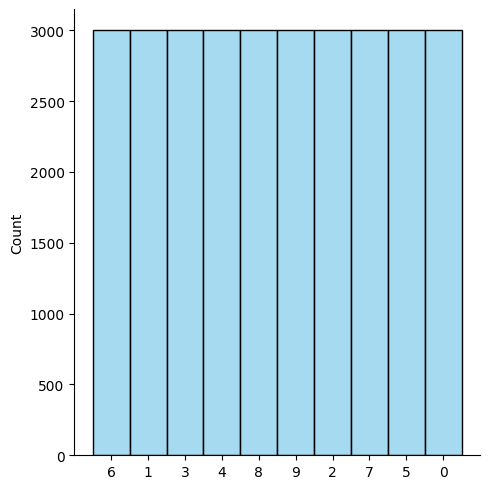

In [6]:
import seaborn as sns
sns.displot(y , color="skyblue", label="Symdol Length");

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, train_size=0.9, shuffle=False)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

27000
27000
3000
3000


In [41]:
import torch
from torch.utils.data import Dataset
import scipy.io.wavfile as wav
import librosa
from torch.nn.functional import pad

class AudioMNISTDataset(Dataset):
    def __init__(self, X, Y):
        self.audio = X
        self.labels = Y
        assert(len(self.audio) == len(self.labels))
    
    def __len__(self):
        return len(self.audio)
    
    def get_data(self, file, target_sr=16000):
        data, sr = librosa.load(file)
        down_d = librosa.resample(data, orig_sr=sr, target_sr=target_sr)
        fix_len_d = librosa.util.fix_length(down_d, size=12000)
        return fix_len_d, target_sr
    
    def mfcc_data(self, file):
        data,sr = self.get_data(file)
        data = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)
        return data
    
    def __getitem__(self, idx):
        audio_seq = self.mfcc_data(self.audio[idx])
        label = torch.tensor(int(self.labels[idx]))
        
        audio_seq = torch.tensor(audio_seq).to(dtype=torch.float32)
        return audio_seq, label

In [42]:
train_dataset = AudioMNISTDataset(X_train, y_train)
test_dataset = AudioMNISTDataset(X_test, y_test)

In [43]:
from torch.utils.data import DataLoader

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [44]:
for audio_seq, label in train_loader:
    print(audio_seq.shape)
    print(label)
    break

torch.Size([4, 40, 24])
tensor([9, 9, 3, 6])


In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AudioClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv1d(40, 32, kernel_size=3, stride=1, padding=0)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=0)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [46]:
model = AudioClassifier(num_classes=10)

In [47]:
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 1e-5
optimizer = Adam(model.parameters(), lr=lr)

cuda


In [48]:
!pip install wandb -qU
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

train/accuracy,▁
train/train_loss,▁
val/val_accuracy,▁
val/val_loss,▁
train/accuracy,0.50134
train/train_loss,1.99351
val/val_accuracy,0.641
val/val_loss,1.85786


Epoch [1/5], train Loss: 2.0100, train accuracy: 0.4896,  val Loss: 1.8332, val accuracy: 0.6800
best model saved!
Epoch [2/5], train Loss: 1.7372, train accuracy: 0.7532,  val Loss: 1.7437, val accuracy: 0.7470
best model saved!
Epoch [3/5], train Loss: 1.6759, train accuracy: 0.8018,  val Loss: 1.6741, val accuracy: 0.8267
best model saved!
Epoch [4/5], train Loss: 1.5990, train accuracy: 0.8761,  val Loss: 1.6335, val accuracy: 0.8460
best model saved!
Epoch [5/5], train Loss: 1.5858, train accuracy: 0.8833,  val Loss: 1.6182, val accuracy: 0.8610
best model saved!


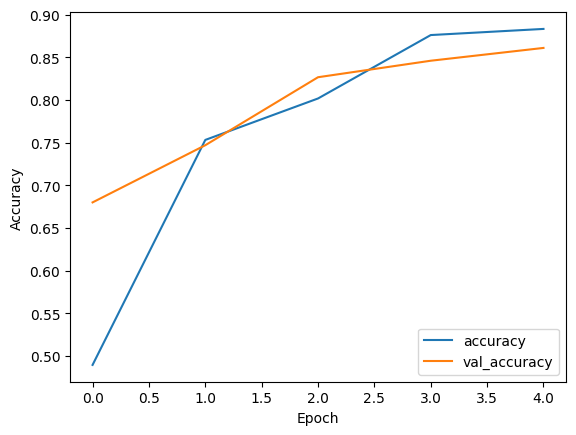

In [49]:
import matplotlib.pyplot as plt
import copy

epochs = 5

accuracy_history = []
val_accuracy_history = []
loss_history = []
val_loss_history = []

best_val_loss = float('inf')
best_model = None

#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

wandb.init(
    project="pytorch-audio",
    name = "audio_MNIST_1",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": lr
        })

# Copy your config
config = wandb.config


for epoch in range(config.epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
    accuracy_history.append(epoch_accuracy.detach().cpu().numpy())
    loss_history.append(epoch_loss.detach().cpu().numpy())

    metrics = {"train/train_loss": epoch_loss,
                "train/accuracy": epoch_accuracy}


    with torch.no_grad():

        epoch_val_accuracy=0
        epoch_val_loss =0

        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output,label)


            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
        print(f'Epoch [{epoch+1}/{epochs}], train Loss: {epoch_loss:.4f}, train accuracy: {epoch_accuracy:.4f},  val Loss: {epoch_val_loss:.4f}, val accuracy: {epoch_val_accuracy:.4f}')
        val_accuracy_history.append(epoch_val_accuracy.detach().cpu().numpy())
        val_loss_history.append(epoch_val_loss.detach().cpu().numpy())

        val_metrics = {"val/val_loss": epoch_val_loss,
                       "val/val_accuracy": epoch_val_accuracy}
        wandb.log({**metrics, **val_metrics})

        if epoch_val_loss < best_val_loss:
            
            best_val_loss = epoch_val_loss
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(), 'best_model.pt')
            print('best model saved!')


plt.plot(accuracy_history, label='accuracy')
plt.plot(val_accuracy_history, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from tqdm import tqdm

def train_one_epoch(model, dataloader, loss_fn, optimizer, device, print_interval=50):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for iteration, (audio, label) in enumerate(tqdm(dataloader, desc="Training")):
        audio = audio.to(device)
        label = label.to(device)

        # Forward pass
        preds = model(audio)
        loss = loss_fn(preds, label)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update total loss
        total_loss += loss.item()

        # Calculate top-1 accuracy
        _, predicted_labels = torch.max(preds, 1)
        correct_predictions += (predicted_labels == label).sum().item()
        total_samples += label.size(0)

        # Print loss and accuracy every print_interval iterations
        if (iteration + 1) % print_interval == 0:
            current_loss = total_loss / (iteration + 1)
            current_accuracy = correct_predictions / total_samples
            print(f"Iteration {iteration + 1}, Average Loss: {current_loss}, Accuracy: {current_accuracy * 100:.2f}%")

    # Calculate average loss and top-1 accuracy
    average_loss = total_loss / len(dataloader)
    top1_accuracy = correct_predictions / total_samples

    return average_loss, top1_accuracy


In [ ]:
NO_EPOCHS = 5
for epoch in range(NO_EPOCHS):
    epoch_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f"Epoch {epoch+1} loss: {epoch_loss}")

In [ ]:
from tqdm import tqdm

def evaluate_model(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for audio, label in tqdm(dataloader, desc="Evaluating"):
            audio = audio.to(device)
            label = label.to(device)

            # Forward pass
            preds = model(audio)
            loss = loss_fn(preds, label)

            # Update total loss
            total_loss += loss.item()

            # Calculate top-1 accuracy
            _, predicted_labels = torch.max(preds, 1)
            correct_predictions += (predicted_labels == label).sum().item()
            total_samples += label.size(0)

    # Calculate average loss and top-1 accuracy
    average_loss = total_loss / len(dataloader)
    top1_accuracy = correct_predictions / total_samples

    print(f"Evaluation Results: Average Loss: {average_loss}, Accuracy: {top1_accuracy * 100:.2f}%")

    return average_loss, top1_accuracy

In [ ]:
average_loss, top1_accuracy = evaluate_model(model, test_loader, loss_fn, device)